# MNIST Image Classification (using a CNN)

## Purpose

The purpose of this notebook is to classify between handwritten digits in the MNIST dataset using a convolutional neural network (CNN). Using a CNN we can achieve extremely high validation accuracy (~99%) due to its excellent feature extraction.  

## Imports

In [0]:
!pip3 install torchvision
!pip3 install tqdm

In [0]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import PIL.ImageOps
from torch import nn
from torchvision import datasets, transforms
from tqdm import tqdm

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Preprocessing the image data from MNIST

Transformations used:

- ToTensor will convert the 28x28 numpy array with pixel brightness values ranging from 0-255 (which is the structure the images in the MNIST dataset are currently in) to a float tensor with pixel brightness values ranging from 0-1

- Normalize will apply normalization to the pixel brightness values (subtract value from mean and then divide by the standard deviation). This makes convergence to minumum loss quicker. 



In [0]:
transform = transforms.Compose([
                               transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                               ]) # defining the transformations we want to make to the images before feeding them into our model
                                                          
training_dataset = datasets.MNIST(root = './data', train=True, download=True, transform=transform) 
validation_dataset = datasets.MNIST(root = './data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size = 100, shuffle=True) # create a dataloader to handle batching of the data. Note that we shuffle the data at each epoch to prevent the gradient descent process from getting stuck in a local minimum, we want it to reach the absolute minimum.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

## Plotting the original training images

In [0]:
def image_convert(tensor): # all this function does is prepeare the images for plotting by changing them from tensors to numpy arrays and also reversing the transforms made when creating training_dataset
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

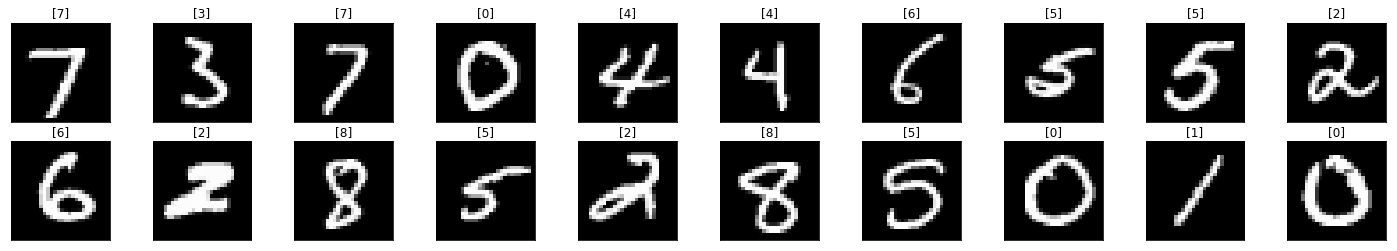

In [0]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  axis = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(image_convert(images[idx]))
  axis.set_title([labels[idx].item()])
  

## Building the model

In [0]:
class LeNet(nn.Module): # note that LeNet is a tried and true CNN model architecture. It consists if 2 convolutional layers (each followed by a pooling layer) to extract the features. Then, after these layers it goes into 2 fully-connected hidden layers for classification.
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1) # arguments here are input_channel size (1 since its black and white image), output_channel size (# of desired features to be extracted), kernel_size, and stride, respectively
    self.conv2 = nn.Conv2d(20, 50, 5, 1) # second convolutional layer
    self.fc1 = nn.Linear(4*4*50, 500) # first fully connected layer. Input size is from the output of the images after passing through the convolutional (and pooling) layers. Output size is arbitrary.
    self.dropout1 = nn.Dropout(0.5) # defining a dropout layer (which will randomly turn off nodes during the training process) to decrease the chance of overfitting occuring
    self.fc2 = nn.Linear(500, 10) # since this is the second fully connected layer, the input size is simply the output size from the 1st fc layer. The output size is 10 since there are 10 potential classes (numbers 0-9) in the MNIST dataset
    
  def forward(self, x):
    x = F.relu(self.conv1(x)) # the input is passed through the first convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the first pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = F.relu(self.conv2(x)) # the input is passed through the second convolutional layer, and ReLu activation function is applied to introduce non-linearity
    x = F.max_pool2d(x, 2, 2) # this is the second pooling layer. The arguements are the images, followed by the kernel size (2), followed by the stride (2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x) # note that we don't apply an activation function here since it will be implictly applied with the nn.CrossEntropyLoss loss function
    return x
    

In [0]:
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss() # we use Cross Entropy Loss for the loss function since it is a multi-class problem. Remember that this function also implicitly applies the log_softmax activation function
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # We use Adam as our optimizer

## Training the model

In [0]:
epochs = 15
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

def train():
  for e in tqdm(range(epochs)):
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      _, preds = torch.max(outputs, 1) # gets the prediction of the model
      running_loss += loss.item()
      running_corrects += torch.sum(preds == labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label

    else: # this block of code is executed after all of the iterations (end of an epoch)
      with torch.no_grad(): # this will set requires_grad = False for the tensors since no gradients need to be taken in this step. This is done to save memory. 
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels)
          
          _, val_preds = torch.max(val_outputs, 1) # gets the prediction of the model
          val_running_loss += val_loss.item()
          val_running_corrects += torch.sum(val_preds == val_labels.data) # counts the number of images classified correctly by comparing the prediction to the corresponding label
        
      epoch_loss = running_loss/len(training_loader) # average loss for each epoch
      epoch_accuracy = running_corrects.float()/len(training_loader) # accuracy for each epoch
      running_loss_history.append(epoch_loss)
      running_corrects_history.append(epoch_accuracy)
      
      val_epoch_loss = val_running_loss/len(validation_loader) # average loss for each epoch
      val_epoch_accuracy = val_running_corrects.float()/len(validation_loader) # accuracy for each epoch
      val_running_loss_history.append(val_epoch_loss)
      val_running_corrects_history.append(val_epoch_accuracy)
      
      print("")
      print("Epoch #{}".format(e+1))
      print("Training loss: {:.4f}, Training Accuracy: {:.4f}".format(epoch_loss, epoch_accuracy.item()))
      print("Validation loss: {:.4f}, Validation Accuracy: {:.4f}".format(val_epoch_loss, val_epoch_accuracy.item()))

    

In [0]:
train()


  7%|▋         | 1/15 [00:19<04:31, 19.41s/it]


Epoch #1
Training loss: 0.6084, Training Accuracy: 83.3983
Validation loss: 0.1972, Validation Accuracy: 94.4600



 13%|█▎        | 2/15 [00:38<04:12, 19.39s/it]


Epoch #2
Training loss: 0.1577, Training Accuracy: 95.2917
Validation loss: 0.1091, Validation Accuracy: 96.8300



 20%|██        | 3/15 [00:58<03:52, 19.36s/it]


Epoch #3
Training loss: 0.1041, Training Accuracy: 96.8817
Validation loss: 0.0803, Validation Accuracy: 97.5100



 27%|██▋       | 4/15 [01:17<03:32, 19.35s/it]


Epoch #4
Training loss: 0.0810, Training Accuracy: 97.5850
Validation loss: 0.0656, Validation Accuracy: 97.9100



 33%|███▎      | 5/15 [01:36<03:13, 19.38s/it]


Epoch #5
Training loss: 0.0664, Training Accuracy: 98.0317
Validation loss: 0.0563, Validation Accuracy: 98.1200



 40%|████      | 6/15 [01:56<02:54, 19.36s/it]


Epoch #6
Training loss: 0.0570, Training Accuracy: 98.2867
Validation loss: 0.0487, Validation Accuracy: 98.3400



 47%|████▋     | 7/15 [02:15<02:34, 19.37s/it]


Epoch #7
Training loss: 0.0500, Training Accuracy: 98.4550
Validation loss: 0.0469, Validation Accuracy: 98.5800



 53%|█████▎    | 8/15 [02:34<02:15, 19.35s/it]


Epoch #8
Training loss: 0.0456, Training Accuracy: 98.5817
Validation loss: 0.0440, Validation Accuracy: 98.5100



 60%|██████    | 9/15 [02:54<01:56, 19.36s/it]


Epoch #9
Training loss: 0.0429, Training Accuracy: 98.7000
Validation loss: 0.0429, Validation Accuracy: 98.6100



 67%|██████▋   | 10/15 [03:13<01:36, 19.36s/it]


Epoch #10
Training loss: 0.0372, Training Accuracy: 98.8483
Validation loss: 0.0372, Validation Accuracy: 98.8100



 73%|███████▎  | 11/15 [03:32<01:17, 19.35s/it]


Epoch #11
Training loss: 0.0345, Training Accuracy: 98.9583
Validation loss: 0.0348, Validation Accuracy: 98.8600



 80%|████████  | 12/15 [03:52<00:58, 19.35s/it]


Epoch #12
Training loss: 0.0326, Training Accuracy: 98.9833
Validation loss: 0.0335, Validation Accuracy: 98.9500



 87%|████████▋ | 13/15 [04:11<00:38, 19.34s/it]


Epoch #13
Training loss: 0.0299, Training Accuracy: 99.0833
Validation loss: 0.0323, Validation Accuracy: 98.9800



 93%|█████████▎| 14/15 [04:30<00:19, 19.35s/it]


Epoch #14
Training loss: 0.0267, Training Accuracy: 99.2083
Validation loss: 0.0301, Validation Accuracy: 98.9800



100%|██████████| 15/15 [04:50<00:00, 19.33s/it]



Epoch #15
Training loss: 0.0264, Training Accuracy: 99.1833
Validation loss: 0.0278, Validation Accuracy: 99.0200


## Plotting the results

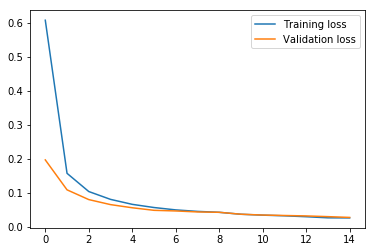

In [0]:
plt.plot(running_loss_history, label="Training loss")
plt.plot(val_running_loss_history, label="Validation loss")
plt.legend()

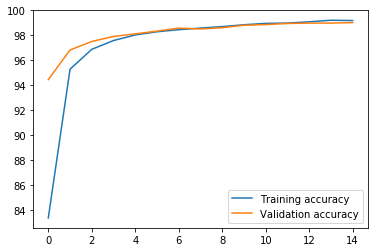

In [0]:
plt.plot(running_corrects_history, label ="Training accuracy")
plt.plot(val_running_corrects_history, label ="Validation accuracy")
plt.legend()

## Final Testing

We will further test the model by grabbing an image of the number '5' from the web, and see how well our model predicts that it's a '5'.

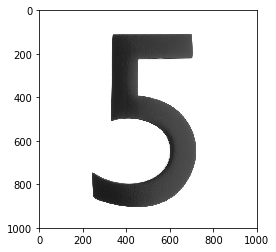

In [0]:
import requests
from PIL import Image

url = "https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg"
response = requests.get(url, stream = True)
img = Image.open(response.raw)

plt.imshow(img)

We must apply some preprocessing to this image so that it can be classified by our model:

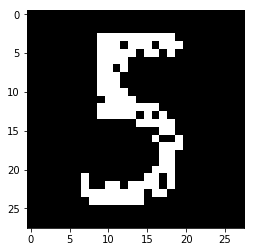

In [0]:
img = PIL.ImageOps.invert(img) # inverts the colours of the image
img = img.convert('1') # converts image to black and white instead of RGB
img = transform(img)
plt.imshow(image_convert(img)) # we have to convert the image back to a numpy array for plt.imshow to render the image

In [0]:
images = img.to(device)
images = images[0].unsqueeze(0).unsqueeze(0) # unsqueezing so it can be fed into the model
output = model(images)
_, pred = torch.max(output, 1) # gets the prediction of the model
print("Prediction is: {}".format(pred.item()))

Prediction is: 5


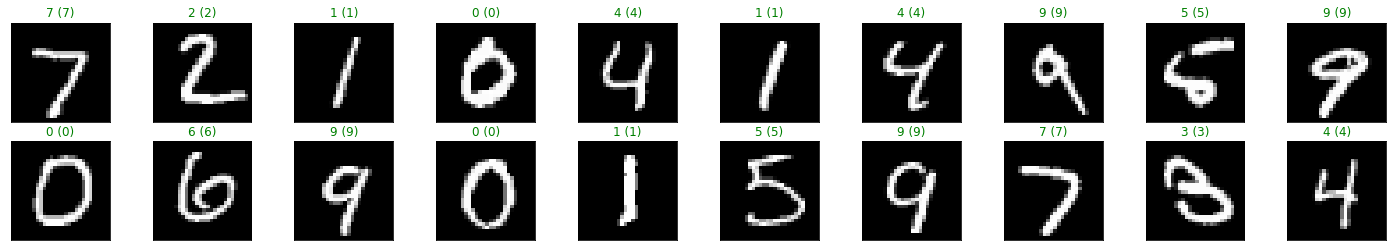

In [0]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)
 
fig = plt.figure(figsize=(25, 4))
 
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(image_convert(images[idx]))
  ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())), color=("green" if preds[idx]==labels[idx] else "red"))